## Kaggle Reuse Experiment
In this notebook, we make the plot in Figure 8 of Section 6.4.

Experiment result is located here:

'./experiment_results/remote/reuse/kaggle_home_credit/cloud-41/2019-10-19/09-49.csv'


In [168]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
FONT_SIZE = 25
LW=6
plt.rcParams.update({
    "lines.markersize": 15,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
plt.rc('hatch', color='white', linewidth=LW)

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
ALL_MAT_COLOR = sns.color_palette()[1]
HELIX_COLOR = sns.color_palette()[2]
ALL_COMPUTE_COLOR = sns.color_palette()[3]
BOTTOMUP_COLOR = sns.color_palette()[4]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/reuse'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')

In [169]:
result_folder = ROOT_RESULT_FOLDER + '/reuse/kaggle_home_credit'
# IN PAPER = result_folder + '/cloud-41/2019-10-19/09-49.csv'
result_file = result_folder + '/cloud-41/2020-02-04/09-49.csv'

In [170]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','reuse_type', 'budget','run_time'
]
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
reuse_map = {'linear':'LN','all_mat':'ALL_M', 'all_compute':'ALL_C', 'bottomup':'BU', 'helix':'HL'}
reuse_result = pd.read_csv(result_file, header=None, names=HEADERS)
reuse_result['workload_order'] = reuse_result['workload'].replace(execution_order)
reuse_result['reuse_type'] = reuse_result['reuse_type'].replace(reuse_map)
reuse_result = reuse_result[reuse_result.reuse_type != 'BU']
reuse_result['cumulative_run_time'] = reuse_result.groupby(['exp_id', 'reuse_type'])['run_time'].apply(lambda x: x.cumsum())

In [171]:
simple_df = reuse_result[reuse_result.mat_type == 'simple']
ss_df = reuse_result[reuse_result.mat_type == 'storage_aware']

In [172]:
simple_df = simple_df.groupby(['workload_order','reuse_type'])['cumulative_run_time'].mean().reset_index()
ss_df = ss_df.groupby(['workload_order','reuse_type'])['cumulative_run_time'].mean().reset_index()

In [173]:
df = simple_df[simple_df.reuse_type == 'ALL_C'][['workload_order','cumulative_run_time']]
simple_df = simple_df.merge(df, on='workload_order', suffixes=('','_ALL_C'))
simple_df['speed_up']=simple_df['cumulative_run_time_ALL_C']/simple_df['cumulative_run_time']

In [174]:
df = ss_df[ss_df.reuse_type == 'ALL_C'][['workload_order','cumulative_run_time']]
ss_df = ss_df.merge(df, on='workload_order', suffixes=('','_ALL_C'))
ss_df['speed_up']=ss_df['cumulative_run_time_ALL_C']/ss_df['cumulative_run_time']

In [184]:
ss_df

,workload_order,reuse_type,cumulative_run_time,cumulative_run_time_ALL_C,speed_up
0,1,ALL_C,200.195100,200.195100,1.000000
1,1,ALL_M,200.505934,200.195100,0.998450
2,1,HL,202.821433,200.195100,0.987051
3,1,LN,200.043097,200.195100,1.000760
4,2,ALL_C,371.558663,371.558663,1.000000
5,2,ALL_M,371.948438,371.558663,0.998952
6,2,HL,375.832245,371.558663,0.988629
7,2,LN,370.988461,371.558663,1.001537
8,3,ALL_C,668.560841,668.560841,1.000000
9,3,ALL_M,667.124028,668.560841,1.002154


In [175]:
def plot_executions_times(df,ax, mat_type):
    #plt.figure(figsize=(8, 4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='cumulative_run_time',
        hue='reuse_type',
        style='reuse_type',
        ax=ax,
        markers={
            'LN': "o",
            'HL':'X',
            'ALL_M': "^",
            'ALL_C': 'v'
        },
        lw=LW,
        ci='sd',
        hue_order=['LN', 'HL', 'ALL_M', 'ALL_C'],
        # style_order = ['baseline', 'optimized'],
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
            'ALL_M': (3, 1),
            'ALL_C': (1, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')

    plot.set_xlabel('Workload\n{}'.format(mat_type))
    plot.set_ylabel('Cumulative \nRun Time (s)')
    plot.set_ylim((0, 2200))
    plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    plot.get_legend().remove()
    ax.tick_params(axis='both', which='major', pad=-2)
    
    return plot

In [176]:
def plot_speedup(df,ax, mat_type):
    plot = sns.lineplot(
        data=df[df.reuse_type!='ALL_C'],
        x='workload_order',
        y='speed_up',
        hue='reuse_type',
        style='reuse_type',
        ax=ax,
        markers={
            'LN': "o",
            'HL':'X',
            'ALL_M': "^",
            #'ALL_C': 'v'
        },
        lw=LW,
        ci='sd',
        hue_order=['LN', 'HL', 'ALL_M'],
        # style_order = ['baseline', 'optimized'],
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
            'ALL_M': (3, 1),
            #'ALL_C': (1, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            #'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')

    plot.set_xlabel('Workload\n{}'.format(mat_type))
    plot.set_ylabel('Speedup')
    #plot.set_xlim((1,2))
    plot.set_ylim((.7, 2.5))
    plot.set_yticks([1, 2])
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    plot.get_legend().remove()
    ax.tick_params(axis='both', which='major', pad=-2)
    
    return plot

In [177]:
# plt.clf()
# fig, axs = plt.subplots(ncols=2, nrows=1,figsize=(12,3.5))
# #ax1 = fig.add_subplot(131)
# p1=plot_speedup(simple_df,axs[0],'\\textbf{{(a) Heuristics-based}}')

# #ax2 = fig.add_subplot(132,sharey=ax1)
# p2=plot_speedup(ss_df,axs[1], '\\textbf{{(b) Storage-aware}}')

# #ax3 = fig.add_subplot(133)
# # df = reuse_result[reuse_result.mat_type == 'helix']
# # p3=plot_executions_times(df,axs[2], '\\textbf{{(c) HL}}')
# # fig.tight_layout()

# #p2.yaxis.label.set_visible(False)
# #plt.setp(p2.get_yticklabels(), visible=False)
# #p3.yaxis.label.set_visible(False)
# #plt.setp(p3.get_yticklabels(), visible=False)

# handles = []
# labels = ['LN', 'HL', 'ALL\_M', 'ALL\_C']
# # del handles[0]
# from matplotlib.lines import Line2D
# handles.append(Line2D([0], [1],
#                     color=SYSTEM_COLOR,
#                     lw=LW,
#                     dashes=(1, 0),
#                     marker="o",
#                     markersize=15))
# handles.append(Line2D([0], [1],
#                     color=HELIX_COLOR,
#                     lw=LW,
#                     dashes=(3, 1),
#                     marker="X",
#                     markersize=15))
# handles.append(Line2D([0], [1],
#                     color=ALL_MAT_COLOR,
#                     lw=LW,
#                     dashes=(2, 2),
#                     marker="^",
#                     markersize=15))
# handles.append(Line2D([0], [1],
#                     color=ALL_COMPUTE_COLOR,
#                     lw=LW,
#                     dashes=(1, 1),
#                     marker="v",
#                     markersize=15))
# legend = fig.legend(
#     handles,
#     labels,
#     borderpad=0.2,
#     frameon=True,
#     loc='upper center',
#     handlelength=2.5,
#     handletextpad=0.1,
#     numpoints=1,
#     ncol=4,
#     columnspacing=0.5,
#     bbox_to_anchor=(0.55, 1.21))
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(2.0)

# fig.tight_layout(pad=0,h_pad=0,w_pad=0)
# #savefig(output_directory+'/reuse-times')

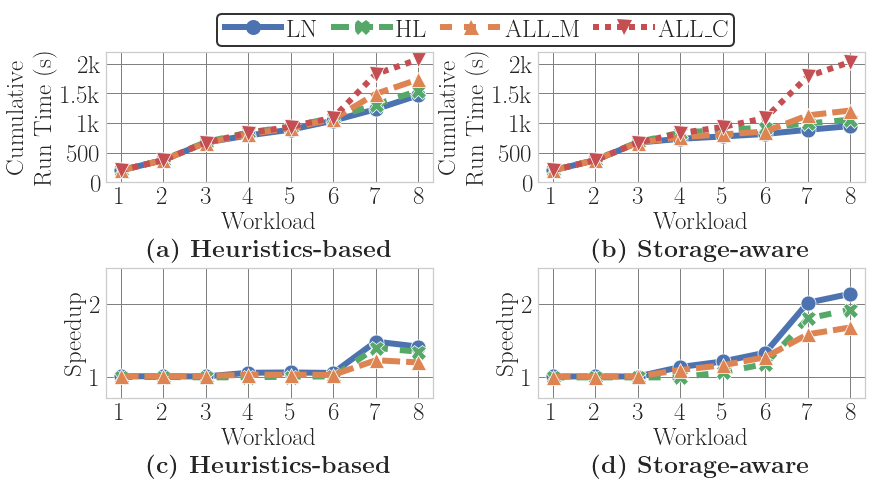

In [183]:
from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 2)
#plt.clf()
#fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(12,7))
#ax1 = fig.add_subplot(131)
ax = plt.subplot(gs[0])
p1=plot_executions_times(simple_df,ax,'\\textbf{{(a) Heuristics-based}}')

ax = plt.subplot(gs[1])
p2=plot_executions_times(ss_df,ax, '\\textbf{{(b) Storage-aware}}')

ax = plt.subplot(gs[2])
p1=plot_speedup(simple_df,ax,'\\textbf{{(c) Heuristics-based}}')

ax = plt.subplot(gs[3])
p2=plot_speedup(ss_df,ax, '\\textbf{{(d) Storage-aware}}')

handles = []
labels = ['LN', 'HL', 'ALL\_M', 'ALL\_C']
# del handles[0]
from matplotlib.lines import Line2D
handles.append(Line2D([0], [1],
                    color=SYSTEM_COLOR,
                    lw=LW,
                    dashes=(1, 0),
                    marker="o",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=HELIX_COLOR,
                    lw=LW,
                    dashes=(3, 1),
                    marker="X",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=ALL_MAT_COLOR,
                    lw=LW,
                    dashes=(2, 2),
                    marker="^",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=ALL_COMPUTE_COLOR,
                    lw=LW,
                    dashes=(1, 1),
                    marker="v",
                    markersize=15))
legend = fig.legend(
    handles,
    labels,
    borderpad=0.2,
    frameon=True,
    loc='upper center',
    handlelength=2.5,
    handletextpad=0.1,
    numpoints=1,
    ncol=4,
    columnspacing=0.5,
    bbox_to_anchor=(0.55, 1.12))
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2.0)

fig.tight_layout(pad=0,h_pad=0,w_pad=0)
savefig(output_directory+'/reuse-times-speedups')

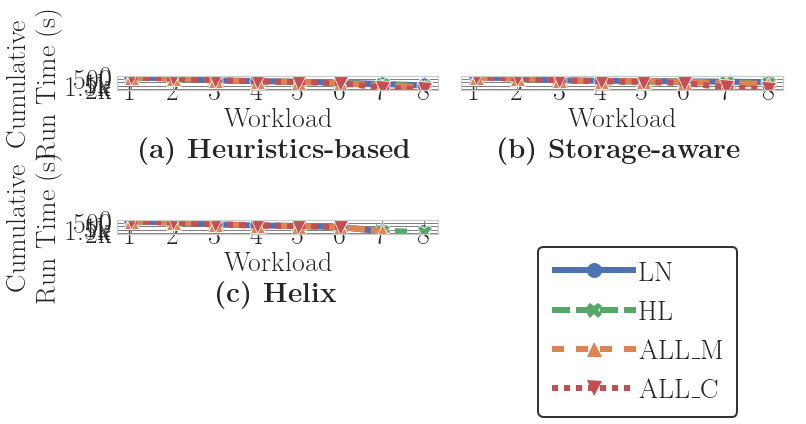

In [146]:
plt.clf()
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(11,4),sharey=True)
#ax1 = fig.add_subplot(131)
df = reuse_result[reuse_result.mat_type == 'simple']
p1=plot_executions_times(df,axs[0,0],'\\textbf{{(a) Heuristics-based}}')

#ax2 = fig.add_subplot(132,sharey=ax1)
df = reuse_result[reuse_result.mat_type == 'storage_aware']
p2=plot_executions_times(df,axs[0,1], '\\textbf{{(b) Storage-aware}}')

#ax3 = fig.add_subplot(133)
df = reuse_result[reuse_result.mat_type == 'helix']
p3=plot_executions_times(df,axs[1,0], '\\textbf{{(c) Helix}}')
fig.tight_layout()

p2.yaxis.label.set_visible(False)
#plt.setp(p2.get_yticklabels(), visible=False)
#p3.yaxis.label.set_visible(False)
#plt.setp(p3.get_yticklabels(), visible=False)

handles = []
labels = ['LN', 'HL', 'ALL\_M', 'ALL\_C']
# del handles[0]
from matplotlib.lines import Line2D
handles.append(Line2D([0], [1],
                    color=SYSTEM_COLOR,
                    lw=LW,
                    dashes=(1, 0),
                    marker="o",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=HELIX_COLOR,
                    lw=LW,
                    dashes=(3, 1),
                    marker="X",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=ALL_MAT_COLOR,
                    lw=LW,
                    dashes=(2, 2),
                    marker="^",
                    markersize=15))
handles.append(Line2D([0], [1],
                    color=ALL_COMPUTE_COLOR,
                    lw=LW,
                    dashes=(1, 1),
                    marker="v",
                    markersize=15))
axs[1,1].axis('off')
legend = axs[1,1].legend(
    handles,
    labels,
    borderpad=0.5,
    frameon=True,
    loc='upper center',
    handlelength=3,
    handletextpad=0.1,
    #fontsize=TICK_LABEL_SIZE,
    numpoints=1,
    ncol=1,
    columnspacing=0.5,
    bbox_to_anchor=(0.55, 0.9))
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2.0)

fig.tight_layout(pad=0,h_pad=0,w_pad=0)
#savefig(output_directory+'/reuse-times')

In [48]:
def plot_executions_times(df, loc=None):
    plt.figure(figsize=(8, 4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='cumulative_run_time',
        hue='reuse_type',
        style='reuse_type',
        markers={
            'LN': "o",
            'HL':'X',
            'ALL_M': "^",
            'ALL_C': 'v'
        },
        lw=LW,
        ci='sd',
        hue_order=['LN', 'HL', 'ALL_M', 'ALL_C'],
        # style_order = ['baseline', 'optimized'],
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
            'ALL_M': (3, 1),
            'ALL_C': (1, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')
    lg = plt.legend(
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        ncol=3,
        columnspacing=0.5,
        bbox_to_anchor=(0.55, 1.2))
    handles = lg.legendHandles
    labels = ['LN', 'HL', 'ALL\_M', 'ALL\_C']
    del handles[0]
    from matplotlib.lines import Line2D
    handles[0] = Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        linewidth=LW - 2,
                        dashes=(1, 0),
                        marker="o")
    handles[1] = Line2D([0], [1],
                        color=HELIX_COLOR,
                        linewidth=LW - 2,
                        dashes=(2, 2),
                        marker="X")
    handles[2] = Line2D([0], [1],
                        color=ALL_MAT_COLOR,
                        linewidth=LW - 2,
                        dashes=(3, 1),
                        marker="^")
    handles[3] = Line2D([0], [1],
                        color=ALL_COMPUTE_COLOR,
                        linewidth=LW - 2,
                        dashes=(1, 1),
                        marker="v")
    legend = plt.legend(
        handles,
        labels,
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        numpoints=1,
        ncol=4,
        columnspacing=0.2,
        bbox_to_anchor=(0.5, 1.27))

    plt.tick_params(labelsize=TICK_LABEL_SIZE)

    plot.set_xlabel('Workload', fontsize=AXIS_FONT)
    plot.set_ylabel('Cumulative \nRun Time (s)', fontsize=AXIS_FONT)
    #plot.set_xlim((1,2))
    plot.set_ylim((0, 2200))
    plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks(range(1, 9))
    plot.set_xticklabels(range(1, 9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    #plt.tight_layout()
    if loc is not None:
        plt.savefig(loc, bbox_inches='tight')

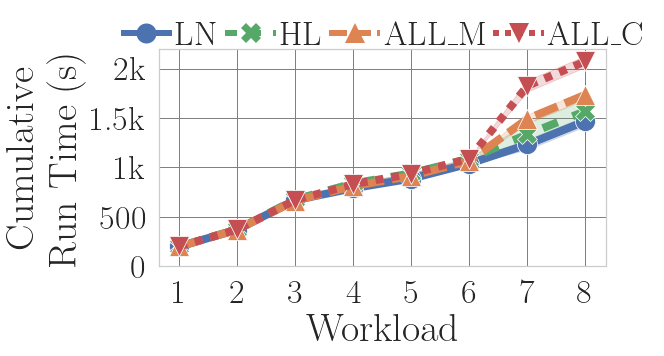

In [42]:
df = reuse_result[reuse_result.mat_type == 'simple']
plot_executions_times(df)
#plot_executions_times(df, output_directory+'/simple-mat.pgf')

In [110]:
df = reuse_result[reuse_result.mat_type == 'simple']

In [111]:
df.groupby(['workload_order','reuse_type']).mean()

budget    run_time  cumulative_run_time
workload_order reuse_type                                             
1              ALL_C       16777216.0  200.963620           200.963620
               ALL_M       16777216.0  200.001384           200.001384
               HL          16777216.0  202.308007           202.308007
               LN          16777216.0  200.209015           200.209015
2              ALL_C       16777216.0  171.927725           372.891345
               ALL_M       16777216.0  171.530838           371.532222
               HL          16777216.0  172.985920           375.293927
               LN          16777216.0  171.577346           371.786361
3              ALL_C       16777216.0  296.934686           669.826031
               ALL_M       16777216.0  293.205066           664.737288
               HL          16777216.0  302.354126           677.648053
               LN          16777216.0  297.352466           669.138827
4              ALL_C       16777216.0  161.040558           830.866589
               ALL_M       16777216.0  147.049424           811.786712
               HL          16777216.0  161.863721           839.511774
               LN          16777216.0  120.869994           790.008821
5              ALL_C       16777216.0  105.830294           936.696883
               ALL_M       16777216.0  101.646007           913.432719
               HL          16777216.0   99.839634           939.351408
               LN          16777216.0   97.044989           887.053810
6              ALL_C       16777216.0  153.082213          1089.779097
               ALL_M       16777216.0  152.487945          1065.920664
               HL          16777216.0  148.647975          1087.999383
               LN          16777216.0  151.449520          1038.503330
7              ALL_C       16777216.0  735.314044          1825.093141
               ALL_M       16777216.0  425.114777          1491.035441
               HL          16777216.0  220.121376          1308.120759
               LN          16777216.0  193.476582          1231.979912
8              ALL_C       16777216.0  247.440697          2072.533838
               ALL_M       16777216.0  243.552060          1734.587501
               HL          16777216.0  235.705306          1543.826065
               LN          16777216.0  235.241056          1467.220968

In [113]:
(1055.328868 - 947.464916)/947.464916

0.11384479802732879

In [115]:
(1543.826065 - 1467.220968)/1467.220968

0.052211015702987064

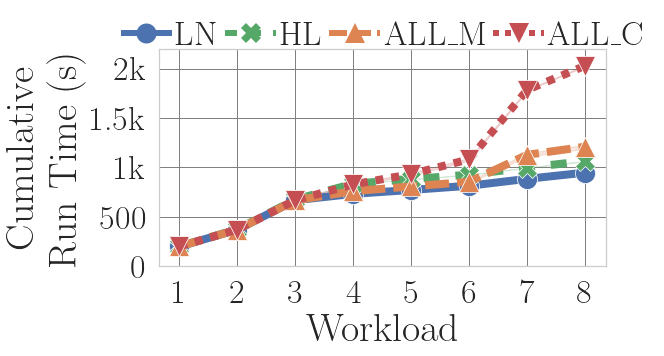

In [43]:
df = reuse_result[reuse_result.mat_type == 'storage_aware']
plot_executions_times(df)
#plot_executions_times(df, output_directory+'/storage-aware-mat.pgf')

In [45]:
df.groupby(['workload_order','reuse_type']).mean()

budget    run_time  cumulative_run_time
workload_order reuse_type                                             
1              ALL_C       16777216.0  202.270039           202.270039
               ALL_M       16777216.0  202.712755           202.712755
               HL          16777216.0  202.194254           202.194254
               LN          16777216.0  202.339981           202.339981
2              ALL_C       16777216.0  173.526312           375.796351
               ALL_M       16777216.0  173.563463           376.276217
               HL          16777216.0  173.764780           375.959034
               LN          16777216.0  173.012679           375.352661
3              ALL_C       16777216.0  303.900952           679.697302
               ALL_M       16777216.0  309.168851           685.445068
               HL          16777216.0  302.034257           677.344166
               LN          16777216.0  300.513590           675.866251
4              ALL_C       16777216.0  161.838465           841.535768
               ALL_M       16777216.0  162.921881           848.366949
               HL          16777216.0  161.717884           839.062050
               LN          16777216.0  160.835306           836.701556
5              ALL_C       16777216.0  104.306559           945.842327
               ALL_M       16777216.0   94.988711           943.355660
               HL          16777216.0   92.057129           931.119179
               LN          16777216.0   94.217511           930.919067
6              ALL_C       16777216.0  149.706254          1095.548581
               ALL_M       16777216.0  151.334862          1094.690523
               HL          16777216.0  149.686733          1080.805912
               LN          16777216.0  149.724473          1080.643541
7              ALL_M       16777216.0  667.839081          1762.529603
               HL          16777216.0  529.062960          1609.868872
               LN          16777216.0  623.792733          1704.436274

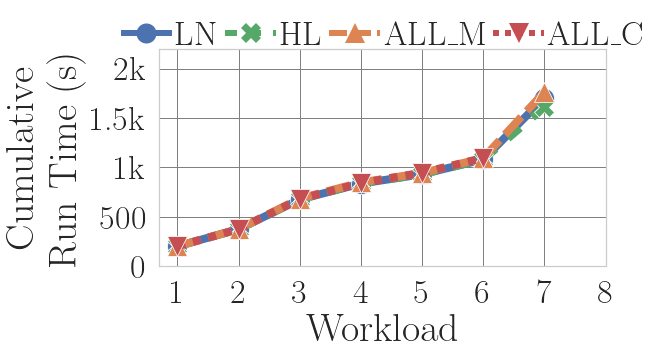

In [44]:
df = reuse_result[reuse_result.mat_type == 'helix']
plot_executions_times(df)
#plot_executions_times(df, output_directory+'/storage-aware-mat.pgf')